# M04. Steals
- This predicts stolen base attempt and success rates
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 12/16/2023
    - Updated: 4/21/2024

Warning: This was modified from M03. Base Running and may contain some vestigial code. This isn't a problem, but just a reminder.

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Read in plays

In [4]:
%%time
# Read in park factors
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))
df = create_pa_inputs(multiplier_df, 2015, 2024, short=50, long=300, adjust=True)
# Keep only regular season games
df = df.query('game_type == "R"')

CPU times: total: 3min 16s
Wall time: 3min 26s


In [5]:
# # Read from CSV
# df = pd.read_csv(os.path.join(baseball_path, "Complete Dataset.csv"))
# # Keep only regular season games
# df = df.query('game_type == "R"')

### Movement Reasons

r_adv_force: advanced on a ball in play because they were forced to <br>
r_adv_play: advanced on a ball in play without being forced to <br>
r_force_out: out on a force play <br>
r_adv_throw: advanced on the throw, not the contact <br>
r_runner_out: out not on a force play <br>
r_thrown_out: out on a hit (base runner) <br>
r_doubled_off: out on a ball caught and thrown to base <br>
r_out_stretching: out on a hit (hitter) <br>

We now have where every runner, including the batter, started and finished. However, we have two problems:
- Some base runners don't move. They are not included in the dataset yet. 
- Some base runners move more than once in a play. They may go from 1B to 2B on a hit and then 2B to 3B on a throw.

### Clean and Create Variables

In [6]:
# Fill in missings
df['description'].fillna("Missing", inplace=True)

# Identify errors
df['error'] = df['description'].str.contains('error', case=False).astype('int')
# Double Play dummy (will be cleaned a bit later)
df['double_play'] = df['eventType'].isin(['grounded_into_double_play', 'double_play', 'sac_fly_double_play', 'strikeout_double_play', 'sac_bunt_double_play']).astype(int)

# Create bottom half inning dummy
df['bottom'] = (df['halfInning'] == "bottom").astype('int')

# Determine outs before at bat
df['outs_pre'] = df.groupby(['gamePk', 'inning', 'bottom'])['outs'].shift(1)
df['outs_pre'] = df.groupby(['gamePk', 'atBatIndex'])['outs_pre'].transform('min')
df['outs_pre'] = np.where(df['outs_pre'] == 3, 0, df['outs_pre'])

# Fill in missings
df['outs_pre'].fillna(0, inplace=True)

### Multiple Movements

Identify where a runner starts and ends in an at bat. Only keep one instance. 

In [7]:
# Determine start and end base by number
# 0 is AB, 1 is 1B, 2 is 2B, 3 is 3B, 4 is scored, 5 is out
df['startInt'] = df['start'].apply(lambda x: 0 if pd.isna(x) else int(x[0]) if x[0].isdigit() else 0)
df['endInt'] = df['end'].apply(lambda x: 5 if pd.isna(x) else 4 if x.lower() == 'score' else int(x[0]) if x[0].isdigit() else 0)

In [8]:
df['minBase'] = df.groupby(['gamePk', 'atBatIndex', 'runner_id'])['startInt'].transform('min')
df['maxBase'] = df.groupby(['gamePk', 'atBatIndex', 'runner_id'])['endInt'].transform('max')

In [9]:
# Extract the number after "id" using regular expression
df['postOnFirst'] = df['postOnFirst'].str.extract(r"'id': (\d+)")
df['postOnSecond'] = df['postOnSecond'].str.extract(r"'id': (\d+)")
df['postOnThird'] = df['postOnThird'].str.extract(r"'id': (\d+)")

In [10]:
# Determine where runners were to start PA
# Note that the exact id may be incorrect due to pinch runners, but we don't really care.
df['preOnFirst'] = df.groupby(['gamePk', 'halfInning'])['postOnFirst'].shift(1)
df['preOnSecond'] = df.groupby(['gamePk', 'halfInning'])['postOnSecond'].shift(1)
df['preOnThird'] = df.groupby(['gamePk', 'halfInning'])['postOnThird'].shift(1)

# Create a mask to identify the first occurrence of each combination
first_occurrence_mask = ~df.duplicated(subset=['gamePk', 'atBatIndex'], keep='first')

# Set 'preOnFirst' to NaN for non-first occurrences
df['preOnFirst'] = df['preOnFirst'].where(first_occurrence_mask, other=None)
df['preOnSecond'] = df['preOnSecond'].where(first_occurrence_mask, other=None)
df['preOnThird'] = df['preOnThird'].where(first_occurrence_mask, other=None)
# Fill in missings
df['preOnFirst'] = df.groupby(['gamePk', 'atBatIndex'])['preOnFirst'].ffill()
df['preOnSecond'] = df.groupby(['gamePk', 'atBatIndex'])['preOnSecond'].ffill()
df['preOnThird'] = df.groupby(['gamePk', 'atBatIndex'])['preOnThird'].ffill()

### Batters

In [11]:
atBat = df.query('id == batter')

# Only keep runners at bat
atBat.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

### Runners on 1B

In [12]:
on1B = df[~df['preOnFirst'].isna()]

# Step 1: Create a dummy column is_runner = 1 if column id == preOnFirst
on1B['is_runner'] = (on1B['start'] == "1B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on1B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnFirst for instances where there are no runners
on1B.loc[no_runner_mask, 'id'] = on1B.loc[no_runner_mask, 'preOnFirst']
on1B.loc[no_runner_mask, 'runner_id'] = on1B.loc[no_runner_mask, 'preOnFirst']

# Step 4: Create the added_1b column
on1B['added_1b'] = 0
on1B.loc[no_runner_mask, 'added_1b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_1b == 1
on1B.loc[on1B['added_1b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 1
on1B.loc[on1B['added_1b'] == 1, ['start', 'end']] = "1B"

# Step 6: Keep one observation per runner
on1B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on1B = on1B.query('minBase == 1')

### Runners on 2B

In [13]:
on2B = df[~df['preOnSecond'].isna()]

# Step 1: Create a dummy column is_runner = 1 if column id == preOnSecond
on2B['is_runner'] = (on2B['start'] == "2B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on2B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnSecond for instances where there are no runners
on2B.loc[no_runner_mask, 'id'] = on2B.loc[no_runner_mask, 'preOnSecond']
on2B.loc[no_runner_mask, 'runner_id'] = on2B.loc[no_runner_mask, 'preOnSecond']

# Step 4: Create the added_2b column
on2B['added_2b'] = 0
on2B.loc[no_runner_mask, 'added_2b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_2b == 1
on2B.loc[on2B['added_2b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 2
on2B.loc[on2B['added_2b'] == 1, ['start', 'end']] = "2B"

# Step 6: Keep one observation per runner
on2B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on2B = on2B.query('minBase == 2')

### Runners on 3B

In [14]:
on3B = df[~df['preOnThird'].isna()]

# Step 1: Create a dummy column is_runner = 1 if column id == preOnSecond
on3B['is_runner'] = (on3B['start'] == "3B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on3B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnSecond for instances where there are no runners
on3B.loc[no_runner_mask, 'id'] = on3B.loc[no_runner_mask, 'preOnThird']
on3B.loc[no_runner_mask, 'runner_id'] = on3B.loc[no_runner_mask, 'preOnThird']

# Step 4: Create the added_2b column
on3B['added_3b'] = 0
on3B.loc[no_runner_mask, 'added_3b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_3b == 1
on3B.loc[on3B['added_3b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 3
on3B.loc[on3B['added_3b'] == 1, ['start', 'end']] = "3B"

# Step 6: Keep one observation per runner
on3B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on3B = on3B.query('minBase == 3')

### Combine

In [15]:
# Concatenate the original DataFrame with the modified rows
df = pd.concat([atBat, on1B, on2B, on3B], ignore_index=True)

# Count up observations within an atBatIndex
df['atBatIndexNum'] = df.groupby(['gamePk', 'atBatIndex']).cumcount() + 1

# Sort
df.sort_values(['gamePk', 'atBatIndex', 'atBatIndexNum'], inplace=True)

### Start Locations

In [16]:
# Any runner started on these bases
# Create start location dummies
df['pre_1b'] = (df['minBase'] == 1).astype('int')
df['pre_2b'] = (df['minBase'] == 2).astype('int')
df['pre_3b'] = (df['minBase'] == 3).astype('int')

# Group by 'gamePk' and 'atBatIndex', then use transform to calculate the max for each group
df['pre_1b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_1b'].transform('max')
df['pre_2b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_2b'].transform('max')
df['pre_3b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_3b'].transform('max')

### Fix End Locations

In [17]:
# End locations: Runner
df['post_1b'] = (df['maxBase'] == 1).astype('int')
df['post_2b'] = (df['maxBase'] == 2).astype('int')
df['post_3b'] = (df['maxBase'] == 3).astype('int')

# End locations: At Bat (team)
df['post_1b'] = df.groupby(['gamePk', 'atBatIndex'])['post_1b'].transform('max')
df['post_2b'] = df.groupby(['gamePk', 'atBatIndex'])['post_2b'].transform('max')
df['post_3b'] = df.groupby(['gamePk', 'atBatIndex'])['post_3b'].transform('max')

# End locations: Blocked - this occurs when someone other than the runner is already on a base
# Note: You can't be blocked from advancing to a base you're on or have passed
df['blocked_1b'] = ((df['post_1b'] == 1) & (df['maxBase'] < 1)).astype('int')
df['blocked_2b'] = ((df['post_2b'] == 1) & (df['maxBase'] < 2)).astype('int')
df['blocked_3b'] = ((df['post_3b'] == 1) & (df['maxBase'] < 3)).astype('int')

### Events

In [18]:
# Create game events
df = create_events(df)

# Encode events as integer
df['eventsModelInt'] = df['eventsModel'].map({'b1': 1, 'b2': 2, 'b3': 3, 'hr': 4, 'bb': 5, 'hbp': 6, 'so': 7, 'fo': 8, 'go': 9, 'lo': 10, 'po': 11})

### Out locations

In [19]:
# Determine if a runner is out
df['out'] = (df['maxBase'] == 5).astype('int')

df['out_home'] = ((df['out'] == 1) & (df['minBase'] == 0)).astype('int')
df['out_1b'] = ((df['out'] == 1) & (df['minBase'] == 1)).astype('int')
df['out_2b'] = ((df['out'] == 1) & (df['minBase'] == 2)).astype('int')
df['out_3b'] = ((df['out'] == 1) & (df['minBase'] == 3)).astype('int')

df['out_home'] = df.groupby(['gamePk', 'atBatIndex'])['out_home'].transform('max')
df['out_1b'] = df.groupby(['gamePk', 'atBatIndex'])['out_1b'].transform('max')
df['out_2b'] = df.groupby(['gamePk', 'atBatIndex'])['out_2b'].transform('max')
df['out_3b'] = df.groupby(['gamePk', 'atBatIndex'])['out_3b'].transform('max')

### Cuts

In [20]:
# # Drop less relevant events
# df = df.query('eventsModel != "Cut"')

# Duplicates (should be very rare. I believe they're mlb's errors, not mine)
df.drop_duplicates(subset=['gamePk', 'atBatIndex', 'minBase'], keep='first', inplace=True)

# Calculate outs in PA
df['outs_calculated'] = df.groupby(['gamePk', 'atBatIndex'])['out'].transform('sum')

# Sometimes, there will be two outs without a double play recorded (typically a pickoff) but we need these for the math to work
df['double_play'] = np.where(df['outs_calculated'] == 2, 1, df['double_play'])
# Sometimes, there will be no outs on a play that's traditionally an out. These are errors.
df['error'] = np.where((df['outs_calculated'] == 0) & (df['eventType'] == 'fielders_choice'), 1, df['error'])

# Drop triple plays
df = df.query('outs_calculated != 3')

### Read in Steamer

In [21]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [22]:
# Convert to YYYYMMDD int
df['date'] = df['game_date'].str.replace("-", "").astype('int')

In [23]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
df["batter_date"] = df["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))

### Identify steals and attempts

In [24]:
df['sb_2b'] = df['movementReason'].isin(['r_stolen_base_2b']).astype('int') 
df['sb_3b'] = df['movementReason'].isin(['r_stolen_base_3b']).astype('int') 
df['sba_2b'] = df['movementReason'].isin(['r_stolen_base_2b', 'r_caught_stealing_2b', 'r_pickoff_caught_stealing_2b']).astype('int') 
df['sba_3b'] = df['movementReason'].isin(['r_stolen_base_3b', 'r_caught_stealing_3b', 'r_pickoff_caught_stealing_3b']).astype('int') 

In [25]:
# Create year variable
df['year'] = df["date"].astype('str').str[:4].astype('int')

# Creating dummy variables
dummy_years = pd.get_dummies(df['year'], prefix='year').astype('int')

# Concatenating dummy variables with original DataFrame
df = pd.concat([df, dummy_years], axis=1)

# Convert to numeric
df['runner_id'] = df['runner_id'].astype(int)

In [26]:
# Merge
steal_df = pd.merge(df[['year', 'gamePk', 'eventsModel', 'atBatIndex', 'atBatIndexNum', 'minBase', 'maxBase', 'runner_id', 'movementReason', 'batter_date', 'sba_2b', 'sba_3b', 'sb_2b', 'sb_3b', 'outs_pre', 'pre_1b', 'pre_2b', 'pre_3b'] + list(dummy_years.columns)], steamer_hitters_df2[['mlbamid', 'date', 'sba_imp', 'sbr']], left_on=['runner_id', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')

In [27]:
# Sort
steal_df.sort_values(['gamePk', 'atBatIndex', 'atBatIndexNum'], ascending=True, inplace=True)

In [28]:
steal_df.query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query('year == 2022').describe()

,year,gamePk,atBatIndex,atBatIndexNum,minBase,maxBase,runner_id,batter_date,sba_2b,sba_3b,sb_2b,sb_3b,outs_pre,pre_1b,pre_2b,pre_3b,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,mlbamid,date,sba_imp,sbr
count,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000,42868.0000
mean,2022.0000,662252.1292,38.0403,1.7090,1.0000,1.6884,615741.3384,20220636.3637,0.0583,0.0000,0.0446,0.0000,1.1168,1.0000,0.0000,0.1313,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,615741.3384,20220636.3637,0.0722,0.7137
std,0.0000,701.5940,22.2159,0.4542,0.0000,1.3496,59376.6819,634.9293,0.2343,0.0000,0.2064,0.0000,0.7949,0.0000,0.0000,0.3378,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,59376.6819,634.9293,0.0476,0.0266
min,2022.0000,661032.0000,1.0000,1.0000,1.0000,1.0000,405395.0000,20211001.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,405395.0000,20211001.0000,0.0041,0.6387
25%,2022.0000,661647.0000,19.0000,1.0000,1.0000,1.0000,592273.0000,20220520.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,592273.0000,20220520.0000,0.0311,0.6950
50%,2022.0000,662254.0000,38.0000,2.0000,1.0000,1.0000,641470.0000,20220701.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,641470.0000,20220701.0000,0.0607,0.7090
75%,2022.0000,662864.0000,57.0000,2.0000,1.0000,2.0000,664041.0000,20220819.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,664041.0000,20220819.0000,0.1117,0.7280
max,2022.0000,663463.0000,122.0000,2.0000,1.0000,5.0000,687093.0000,20220930.0000,1.0000,0.0000,1.0000,0.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,687093.0000,20220930.0000,0.1500,0.8160


In [29]:
steal_df.query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query('year == 2022')[['maxBase']].value_counts()

maxBase
1          30590
2           6520
5           5737
3             21
Name: count, dtype: int64

# Models

### Steals

### Attempt to steal 2B

In [75]:
%%time
# Select relevant columns and handle missing values
X = steal_df.query('pre_1b == 1 and pre_2b == 0 and minBase == 1')[['outs_pre', 'sba_imp', 'sbr']]
                                                                   # + list(dummy_years.columns)]
y = steal_df.query('pre_1b == 1 and pre_2b == 0 and minBase == 1')['sba_2b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
model_sba_2b = MLPClassifier(hidden_layer_sizes=(30,30), activation='relu', early_stopping=False, max_iter=10, random_state=1)
model_sba_2b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = model_sba_2b.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = model_sba_2b.classes_
probability_columns = [f'sba_2b_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
sba_2b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Save model
sba_2b_filename = f"model_sba_2b_{todaysdate}.sav"
print(sba_2b_filename)

# Save model
pickle.dump(model_sba_2b, open(os.path.join(model_path, sba_2b_filename), 'wb'))

model_sba_2b_20240704.sav
CPU times: total: 5.75 s
Wall time: 5.82 s


In [76]:
sba_2b_df.head()

,outs_pre,sba_imp,sbr,sba_2b,sba_2b_0,sba_2b_1
86110,1.0000,0.0414,0.6110,0,0.9855,0.0145
1687707,0.0000,0.0569,0.7450,0,0.9782,0.0218
2222914,1.0000,0.1401,0.7370,0,0.8677,0.1323
1891304,1.0000,0.0557,0.6960,0,0.9750,0.0250
560230,0.0000,0.0694,0.6380,0,0.9796,0.0204


In [77]:
# Add xtiles (to examine how well predictions match actual results)
sba_2b_df['decile'] = pd.qcut(sba_2b_df['sba_2b_1'], 10, labels=False)
globals()["sba_2b_df_deciles"] = sba_2b_df.groupby('decile')[['sba_2b', 'sba_2b_1']].mean().reset_index()

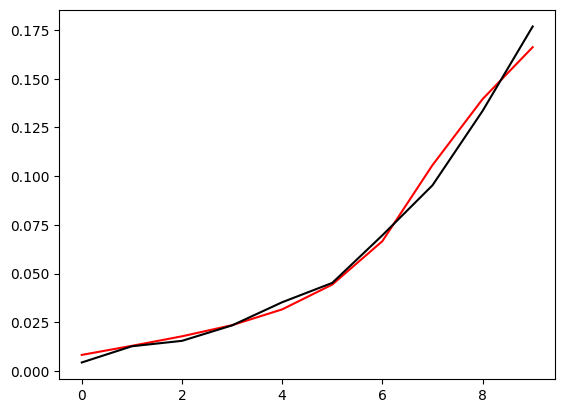

In [78]:
# Create figures
plt.plot(sba_2b_df_deciles['decile'], sba_2b_df_deciles['sba_2b_1'], color='red')
plt.plot(sba_2b_df_deciles['decile'], sba_2b_df_deciles['sba_2b'], color='black')
plt.show() 

In [79]:
sba_2b_df[['sba_2b_1', 'sba_2b']].mean()

sba_2b_1   0.0616
sba_2b     0.0612
dtype: float64

### Attempt to steal 3B

In [35]:
%%time
# Select relevant columns and handle missing values
X = steal_df.query('pre_2b == 1 and pre_3b == 0 and minBase == 2')[['outs_pre', 'sba_imp', 'sbr']] # + list(dummy_years.columns)]
y = steal_df.query('pre_2b == 1 and pre_3b == 0 and minBase == 2')['sba_3b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
model_sba_3b = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', early_stopping=False, max_iter=100, random_state=3)
model_sba_3b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = model_sba_3b.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = model_sba_3b.classes_
probability_columns = [f'sba_3b_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
sba_3b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Save model
sba_3b_filename = f"model_sba_3b_{todaysdate}.sav"
print(sba_3b_filename)

# Save model
pickle.dump(model_sba_3b, open(os.path.join(model_path, sba_3b_filename), 'wb'))

model_sba_3b_20240704.sav
CPU times: total: 4.56 s
Wall time: 4.68 s


In [36]:
# Add xtiles (to examine how well predictions match actual results)
sba_3b_df['decile'] = pd.qcut(sba_3b_df['sba_3b_1'], 10, labels=False)
globals()["sba_3b_df_deciles"] = sba_3b_df.groupby('decile')[['sba_3b', 'sba_3b_1']].mean().reset_index()

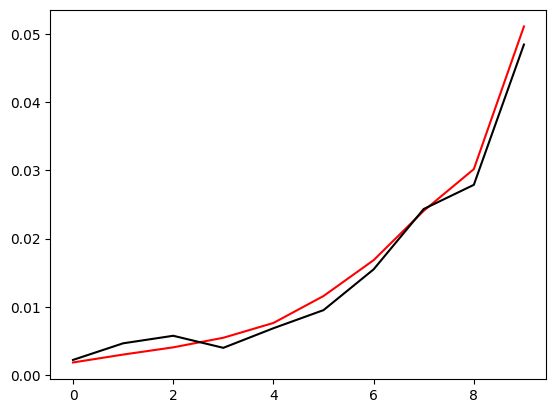

In [37]:
# Create figures
plt.plot(sba_3b_df_deciles['decile'], sba_3b_df_deciles['sba_3b_1'], color='red')
plt.plot(sba_3b_df_deciles['decile'], sba_3b_df_deciles['sba_3b'], color='black')
plt.show() 

In [38]:
sba_3b_df[['sba_3b_1', 'sba_3b']].mean(), sba_3b_df[['sba_3b_1', 'sba_3b']].mean()

(sba_3b_1   0.0156
 sba_3b     0.0149
 dtype: float64,
 sba_3b_1   0.0156
 sba_3b     0.0149
 dtype: float64)

### Steal 2B

In [92]:
%%time
# Select relevant columns and handle missing values
X = steal_df.query('pre_1b == 1 and pre_2b == 0 and sba_2b == 1 and minBase == 1')[['outs_pre', 'sba_imp', 'sbr']] # + list(dummy_years.columns)]
y = steal_df.query('pre_1b == 1 and pre_2b == 0 and sba_2b == 1 and minBase == 1')['sb_2b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
model_sb_2b = MLPClassifier(hidden_layer_sizes=(10,10), activation='relu', max_iter=100, random_state=1)
model_sb_2b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = model_sb_2b.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = model_sb_2b.classes_
probability_columns = [f'sb_2b_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
sb_2b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Save model
sb_2b_filename = f"model_sb_2b_{todaysdate}.sav"
print(sb_2b_filename)

# Save model
pickle.dump(model_sb_2b, open(os.path.join(model_path, sb_2b_filename), 'wb'))

model_sb_2b_20240704.sav
CPU times: total: 1.44 s
Wall time: 1.49 s


In [93]:
# Add xtiles (to examine how well predictions match actual results)
sb_2b_df['decile'] = pd.qcut(sb_2b_df['sb_2b_1'], 10, labels=False)
globals()["sb_2b_df"] = sb_2b_df.groupby('decile')[['sb_2b', 'sb_2b_1']].mean().reset_index()

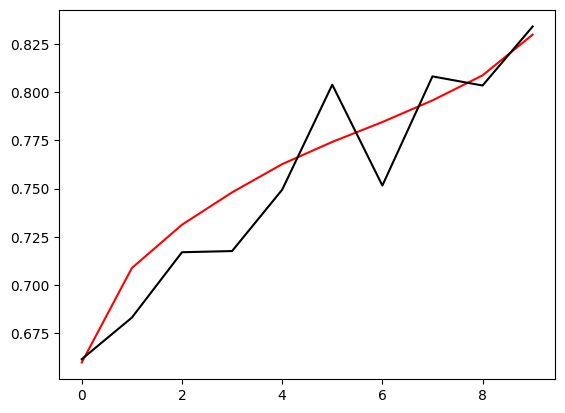

In [94]:
# Create figures
plt.plot(sb_2b_df['decile'], sb_2b_df['sb_2b_1'], color='red')
plt.plot(sb_2b_df['decile'], sb_2b_df['sb_2b'], color='black')
plt.show() 

### Steal 3B

In [60]:
%%time
# Select relevant columns and handle missing values
X = steal_df.query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2')[['outs_pre', 'sba_imp', 'sbr']] # + list(dummy_years.columns)]
y = steal_df.query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2')['sb_3b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
model_sb_3b = MLPClassifier(hidden_layer_sizes=(10,10,), activation='relu', max_iter=100, random_state=42)
model_sb_3b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = model_sb_3b.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = model_sb_3b.classes_
probability_columns = [f'sb_3b_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
sb_3b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Save model
sb_3b_filename = f"model_sb_3b_{todaysdate}.sav"
print(sb_3b_filename)

# Save model
pickle.dump(model_sb_3b, open(os.path.join(model_path, sb_3b_filename), 'wb'))

model_sb_3b_20240704.sav
CPU times: total: 125 ms
Wall time: 141 ms


In [61]:
# Add xtiles (to examine how well predictions match actual results)
sb_3b_df['decile'] = pd.qcut(sb_3b_df['sb_3b_1'], 10, labels=False)
globals()["sb_3b_df"] = sb_3b_df.groupby('decile')[['sb_3b', 'sb_3b_1']].mean().reset_index()

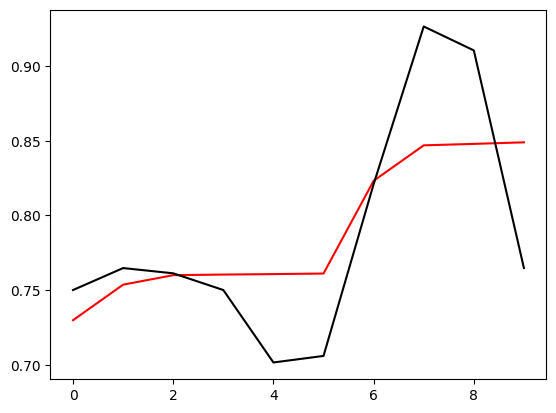

In [62]:
# Create figures
plt.plot(sb_3b_df['decile'], sb_3b_df['sb_3b_1'], color='red')
plt.plot(sb_3b_df['decile'], sb_3b_df['sb_3b'], color='black')
plt.show() 